# NOTES
## Preprocessing steps
1. Define bad and dead channels
    - note: manual inspection first? The authors seemed to go in loops and find the bad channels after all the preprocessing are done (artifacts found in autorejects and IC rejections)
For (each participant):
2. Downsample (1000Hz -> 250Hz)
    - note: original data has 260Hz low pass filter
3. Bandpass Filter (0.1, 30Hz)
4. Remove 50Hz. Original paper: notch Filter (50Hz (48, 52, 1))
5. Remove bad channels (if more than 4: remove participant)
6. Rerefenrence (mastoid)
7. Isolate some data to run ICA (epoching? starting with each new cue)
8. Remove bad trials (find artifacts)
9. Run ICA
10. Perform auto-rejection per ICLabel
11. Interpolation

>NOTE: two-pass preprocessing: go through the preprocessing steps once and then see if there is still bad channels remaining. if so, mark them and start over again.

## To do list
- compare with the results with follow the exact same pipeline as the authors
- process all the participants
- make a separate config file
- (done)need to set a random seed for ICA, otherwise the value is slightly different everytime
- statistical analysis
- cleanup codes, add comments

https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
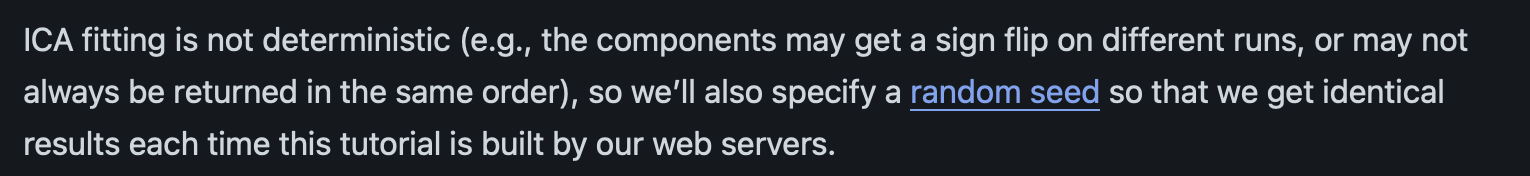

## Things to consider
- do we include the participants that are marked as non-learners by the author? or do we change the criteria a bit? (e.g. 60% -> 55%)
- do we stick to the criteria for early trial rejection? maybe instead of eliminating we can compare between learners and non-learners
- aside from eye blinks, should we reject other ic components? (e.g., heartbeat, muscle, channel noise, other)
- maybe analysis across time to show the effect of learning?

**NOTES**
- nonLearners = [3 5 9 12 20 24 25 29 30 32 33]

## Results under current condition
- condition: IC rejection - eye blink > 50%

| Subject ID | Bad Channels | Notes |
|---|---|---|
| 27 | N/A | |
| 28 | Fp1 | |
| 29 | N/A | |
| 30 (non learner) | N/A | |
| 31 | N/A | |
| 32 (non learner) | N/A | line noise present after bandpass - prove that notch filter is still necessary|
| 33 (non learner) | N/A | |
| 34 | N/A | |
| 35 | TP9&TP10&? | TP9 and TP10 are needed for interpolation. Need to change the current IC rejeciton criteria if we follow the same pipeline|
| 36 | N/A | |
| 37 | N/A | |
| 38 | N/A | |
| | General notes | From manual inspection there seem to be still artifacts (looks regular) after cleaning (not sure if its normal brain reaction after sitmulus or eyeblinks or heartbeats, need to take a second look.)

# Configs

In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import mne
from mne_bids import (BIDSPath,read_raw_bids)
from mne.io import RawArray
import sys
sys.path.insert(0,'.')
import os
import numpy as np

import ccs_eeg_utils
from visualization import show_single_psd, psd_compare, iclabel_visualize, plot_erp
from s01_downsample_filter import down_sampling, band_filter, notch_filter, zapline_filter
from s02_drop_bad_channels import drop_bad_channels, reref
from s03_07_trial_rejection import trial_rejection_cust, trial_rejection_mne
from s04_ICA import get_ica, get_iclabel, iccomponent_removal
from s05_interpolation import interpolation
from s06_early_trial_removal import exclude_early_trials
from s07_epoching import epoching
from s08_find_bad_channels import find_bad_channels
from s09_make_erps import get_evoked

In [151]:
CONDITIONS_DICT = {
    # Feedback-Locked Conditions
    'Low-Low Win':   ['Stimulus:S  6'], 
    'Low-Low Loss':  ['Stimulus:S  7'], 
    'Mid-Low Win':   ['Stimulus:S 16'], 
    'Mid-Low Loss':  ['Stimulus:S 17'], 
    'Mid-High Win':  ['Stimulus:S 26'], 
    'Mid-High Loss': ['Stimulus:S 27'],
    'High-High Win': ['Stimulus:S 36'], 
    'High-High Loss':['Stimulus:S 37'],
}

# Load the dataset
(choose for subject id here)

In [152]:
'''Zheng path'''
#bids_root = "C:\\Users\\Zheng\\Desktop\\fourth semester\\EEG\\reward_dataset\\reward_dataset\\reward_dataset"

'''Qian path'''
bids_root = "/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset"

subject_id = '38'

bids_path = BIDSPath(subject=subject_id, task='casinos',
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)

Extracting parameters from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-38/eeg/sub-38_task-casinos_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-38/eeg/sub-38_task-casinos_events.tsv.
The event "Stimulus" refers to multiple event values.Creating hierarchical event names.
    Renaming event: Stimulus -> Stimulus/S 21
    Renaming event: Stimulus -> Stimulus/S 22
    Renaming event: Stimulus -> Stimulus/S 23
    Renaming event: Stimulus -> Stimulus/S 25
    Renaming event: Stimulus -> Stimulus/S 27
    Renaming event: Stimulus -> Stimulus/S 21
    Renaming event: Stimulus -> Stimulus/S 22
    Renaming event: Stimulus -> Stimulus/S 23
    Renaming event: Stimulus -> Stimulus/S 24
    Renaming event: Stimulus -> Stimulus/S 26
    Renaming event: Stimulus -> Stimulus/S 21
    Renaming event: Stimulus -> Stimulus/S 22
    Renaming event: Stimulus -> Stimulus/

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_10849/2059103975.py:14: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 38
date: 27-Apr-2022 14:06:19
handedness: R
order: mixed 80-20 50-50
stimuli: a cherry an orange
  raw = read_raw_bids(bids_path)


In [153]:
### Examine the raw data, manually mark the bad channels?
#raw.plot()
#raw.get_data()  # extract data as numpy
raw.load_data()  # load to memory

Reading 0 ... 2890439  =      0.000 ...  2890.439 secs...


<RawBrainVision | sub-38_task-casinos_eeg.eeg, 31 x 2890440 (2890.4 s), ~683.7 MiB, data loaded>

>NOTE: from manual inspection, Fp1 and Fp2 have obvious eye blinking artifacts. T7 and T8 seem to have muscle artifacts. (but leave it as it is right now)

# Add Reference

>NOTE: not necessary in MNE. will cause problem for build-in artifact detection 

In [154]:
# # add reference channel for site 2
# info_fz = mne.create_info(
#     ch_names=['Fz'],
#     sfreq=raw.info['sfreq'],
#     ch_types=['eeg']
# )

# # create zero-filled data array for Fz
# n_times = raw.n_times
# zeros_data = np.zeros((1,n_times)) # (num_channels, num_times)
# raw_fz = RawArray(zeros_data, info_fz)

# # merge with original data
# raw.add_channels([raw_fz], force_update_info=True)
# print("Fz channel successfully added to the continuous data.")

# raw.plot()


Refenrence channel shows up as a straight line on the plot
>Q: how is refenrence channel used in the later analysis?

# Set the Montage

In [155]:
#NOTE: download .locs file from author's Github, put it under root_of_dataset/code/..
locs_filename = 'site2channellocations.locs'
locs_path = os.path.join(bids_root, 'code', locs_filename)      
custom_montage = mne.channels.read_custom_montage(locs_path)
raw.set_montage(custom_montage, match_case=False)

<RawBrainVision | sub-38_task-casinos_eeg.eeg, 31 x 2890440 (2890.4 s), ~683.7 MiB, data loaded>

# Downsample

In [156]:
eeg_down = down_sampling(raw)

Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz


# Bandpass

In [157]:
eeg_band = band_filter(eeg_down)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)



# Remove 50Hz Noise

## Option 1: Notch filter

Original setting:  `EEG = pop_eegfiltnew(EEG, 48, 52,[],1)`

In [158]:
eeg_band_notch = notch_filter(eeg_band)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



## Option 2: Zapline filter

In [159]:
eeg_band_zap = zapline_filter(eeg_band)

# for sanity test
#NOTE: when applied on the downsample eeg (not band filtered), zapline does remove the peak at 50Hz (check if zapline is really working)
eeg_down_zap = zapline_filter(eeg_down)


Power of components removed by DSS: 0.00
Power of components removed by DSS: 0.00


# Examine the Effect of Filtering

## Raw vs. Downsampled vs. Bandpass-filtered

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


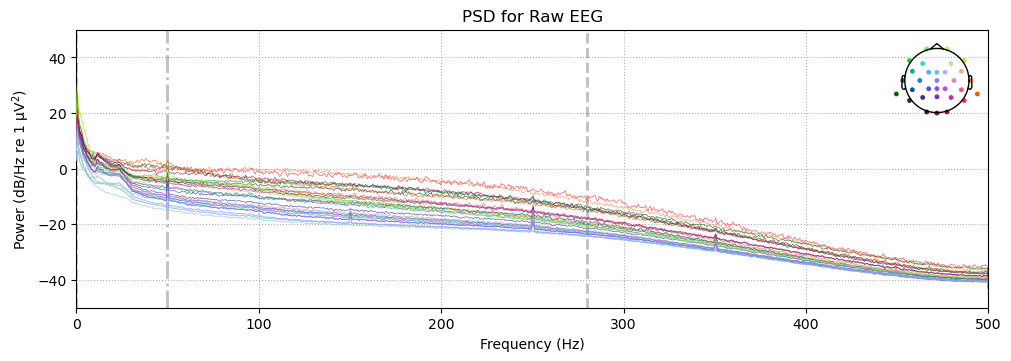

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


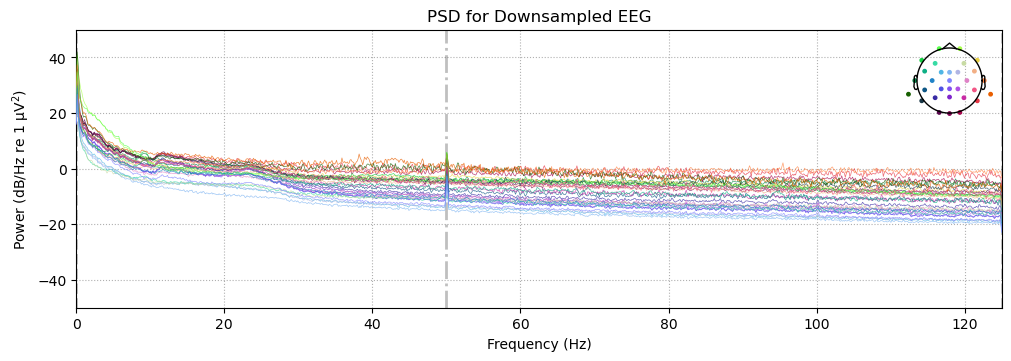

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


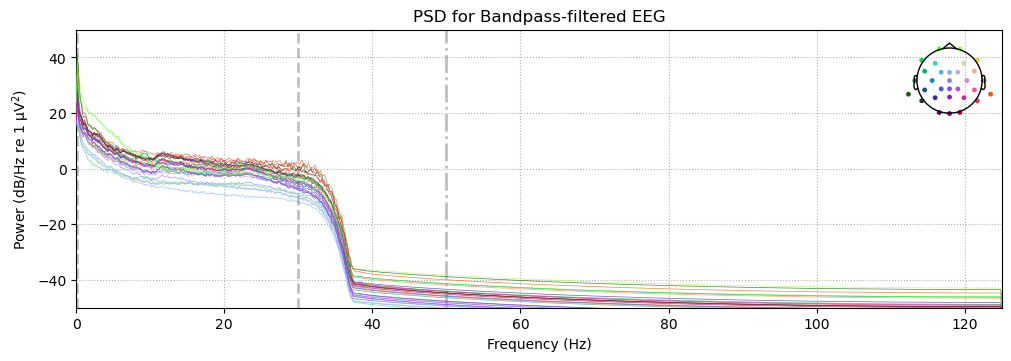

In [160]:
show_single_psd(raw, title="PSD for Raw EEG")
show_single_psd(eeg_down, title="PSD for Downsampled EEG")
show_single_psd(eeg_band, title="PSD for Bandpass-filtered EEG")


>NOTE: as shown on the plot, after band filter the line noise at 50Hz is barely visible

## Bandpass-filtered vs. Band+Notch vs. Band+Zapline

Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)


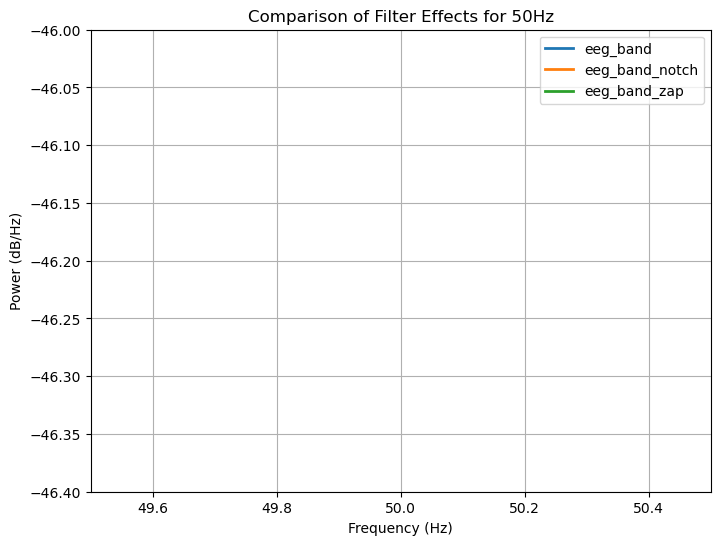

In [161]:
psd_compare((eeg_band, eeg_band_notch, eeg_band_zap), labels=("eeg_band", "eeg_band_notch", "eeg_band_zap"), title="Comparison of Filter Effects for 50Hz")

>NOTE: The leftover noise on 50Hz is negaligable and Zapline is not doing much after the bandpass filter. Choose notch?

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


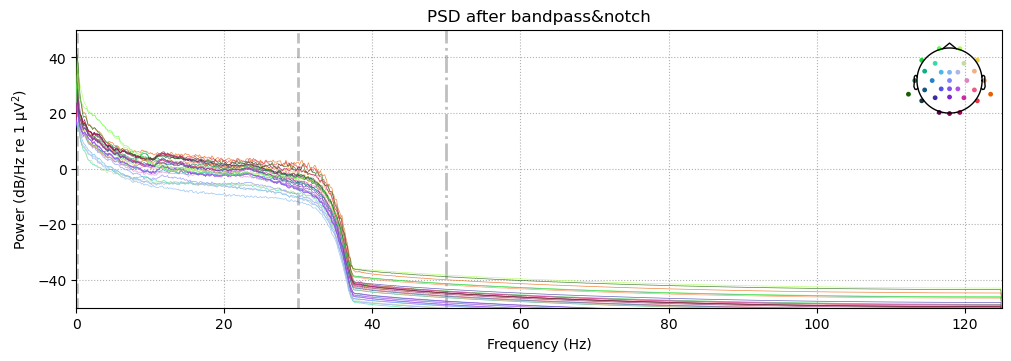

In [162]:
show_single_psd(eeg_band_notch, title="PSD after bandpass&notch")

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


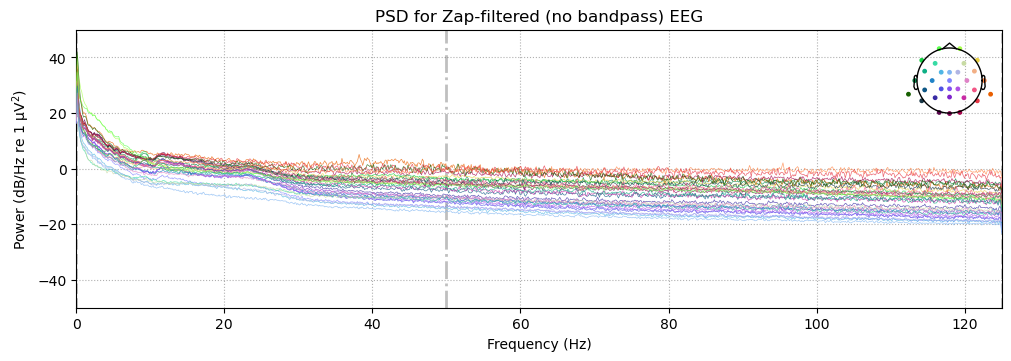

In [163]:
show_single_psd(eeg_down_zap, title="PSD for Zap-filtered (no bandpass) EEG")     # show that zapline can indeed remove 50Hz effectively if there is no bandpass applied before it

# Add Bad Channels

>NOTE: not quite sure but i think they dropped the bad channel for ICA analysis, but need a copy (with bad channels) for interpolation

(need to re ananlysie after setting a random seed for ICA)

- subj 27: None
- subj 28: Fp1
- subj 35: TP9

In [164]:
eeg_ica = drop_bad_channels(subject_id, eeg_band_notch)

bad channels unknown for 38


# Re-referencing

>NOTE: tba - reason for choosing mastoid

In [165]:
eeg_ica = reref(eeg_ica)

Re-referencing to average of mastoids (TP9, TP10).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


# Cleaning in Time (Trial Rejection)

In [166]:
### get the dictionary for the events
evts, evts_dict = mne.events_from_annotations(eeg_ica)
#print(evts_dict)
evts_dict_stim = {k: evts_dict[k] for k in evts_dict.keys() if k in ['Stimulus:S  1', 'Stimulus:S 11', 'Stimulus:S 21', 'Stimulus:S 31']}

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]


## Option 1: stick to the original w/ customized auto-reject script

In [167]:
trials_cust = trial_rejection_cust(eeg_ica, evts, evts_dict_stim, maxMin=500e-6, level=500e-6, step=40e-6, lowest=0.1e-6)

Not setting metadata
432 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 432 events and 751 original time points ...
0 bad epochs dropped
(432, 31, 751)
Using data from preloaded Raw for 432 events and 751 original time points ...
Dropped 1 epoch: 178


## Option 2: leveraging MNE methods (no gradient tho)

In [168]:
trials_mne = trial_rejection_mne(eeg_ica, evts, evts_dict_stim, max=500e-6, min=0.1e-6)
trials_mne.plot_drop_log();

Not setting metadata
432 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 432 events and 751 original time points ...
0 bad epochs dropped


# ICA analysis

Difference between 3 ICA methods:
- Runica
- Picard
- Fastica

>NOTE: need to add random seed, for ICA calculation introduce randomness and the results may be different every time

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 30 components
Fitting ICA took 5.1s.


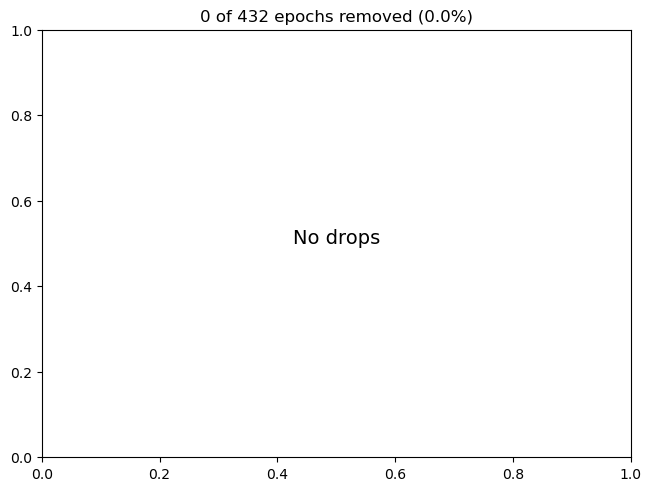

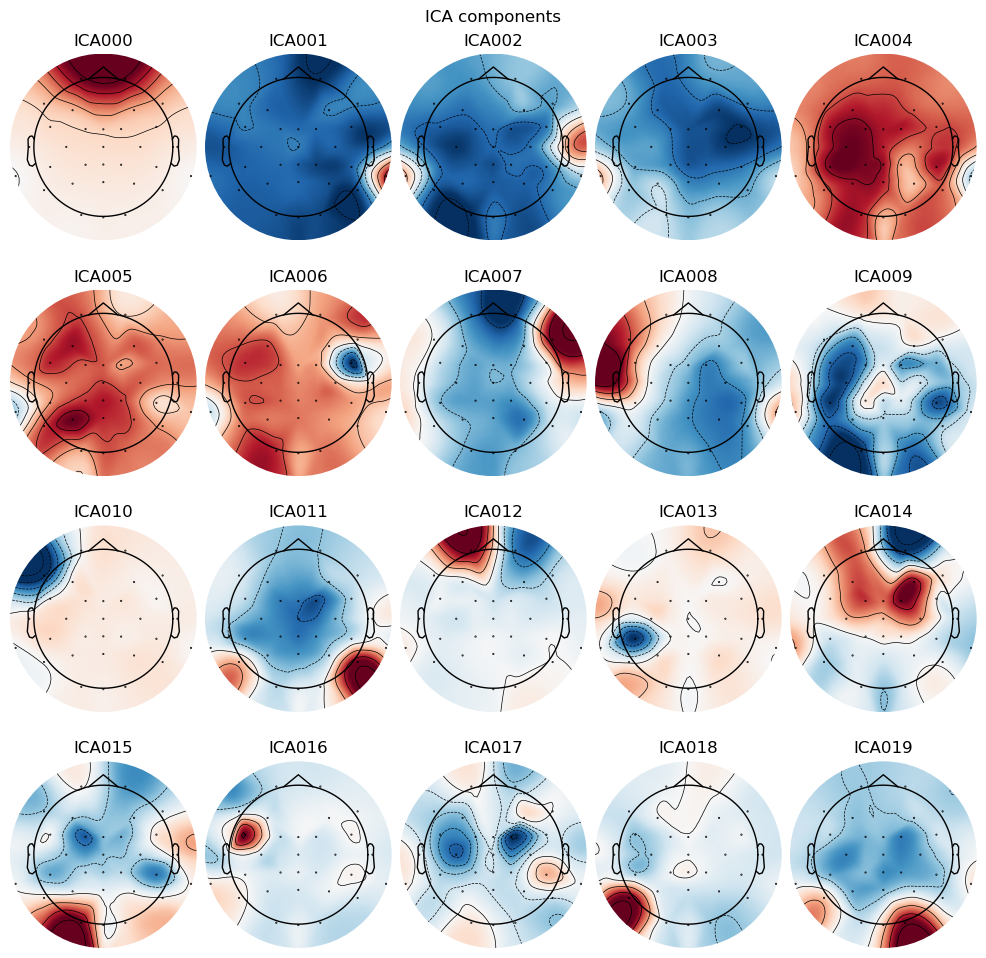

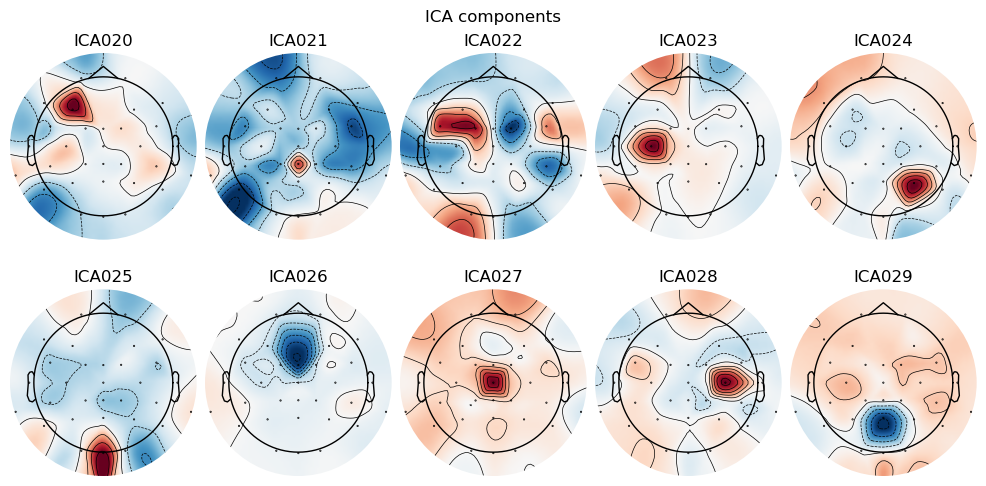

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

In [169]:
ica = get_ica(trials_mne, method="picard")
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
432 matching events found
No baseline correction applied
0 projection items activated


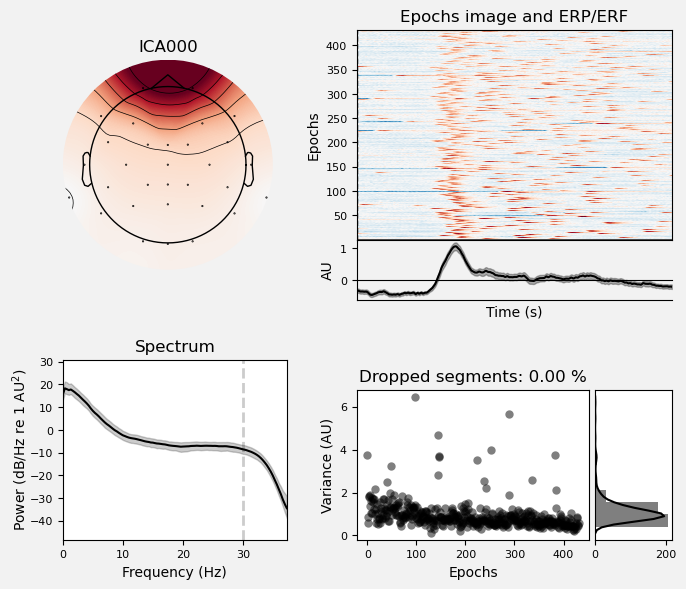

[<Figure size 700x600 with 6 Axes>]

In [170]:
#NOTE: manual inspection. We are using automatic IC rejection?
ica.plot_properties(trials_mne,picks=[0])

# IC Label

/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:34: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:34: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)


['eye blink', 'heart beat', 'other', 'brain', 'brain', 'brain', 'other', 'brain', 'brain', 'other', 'brain', 'brain', 'eye blink', 'other', 'brain', 'other', 'other', 'other', 'brain', 'brain', 'other', 'brain', 'other', 'brain', 'brain', 'other', 'brain', 'other', 'brain', 'brain']
[0.94108325 0.5844446  0.6268951  0.6132334  0.38172555 0.49042335
 0.9644306  0.46018308 0.98538864 0.5893212  0.6166825  0.93663436
 0.45756024 0.53531194 0.51668346 0.6571631  0.9106539  0.7102798
 0.74549514 0.6940416  0.55866843 0.9766862  0.8861337  0.5278967
 0.4943626  0.60980415 0.6146184  0.567929   0.7677698  0.84730136]
numbe of labels: 30


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/visualization.py:102: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.6, wspace=0.1, bottom=0.15)


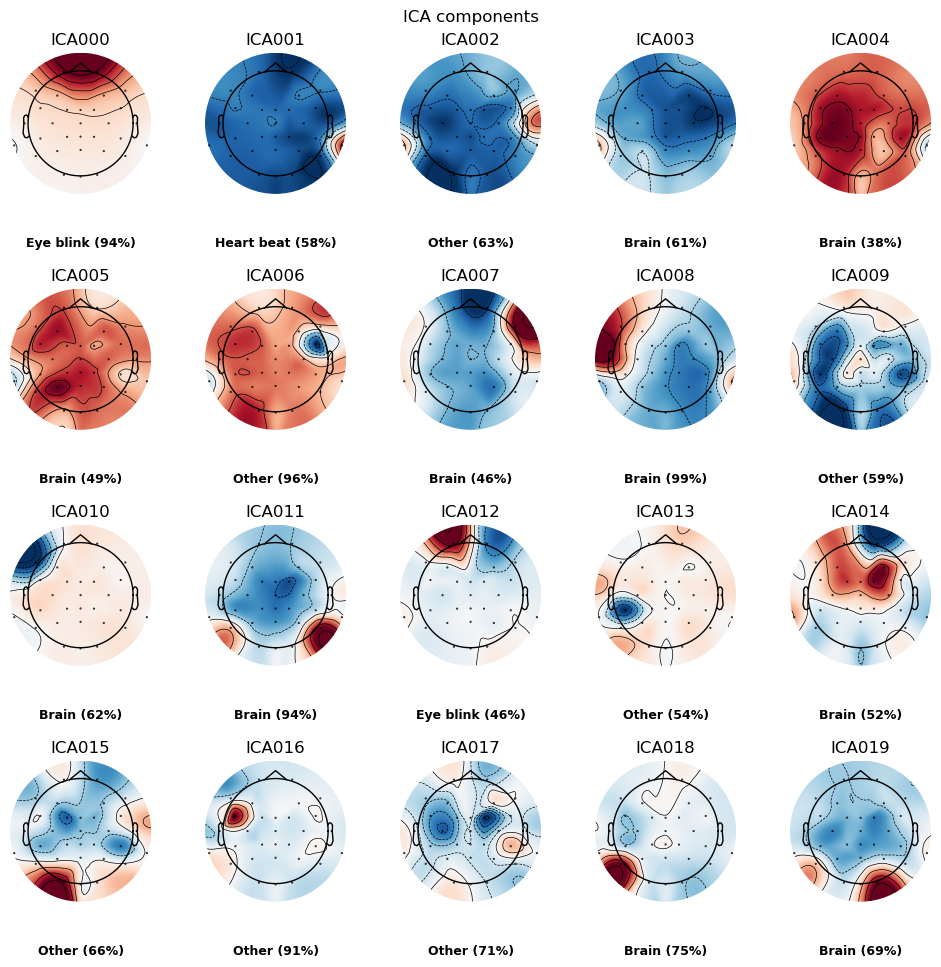

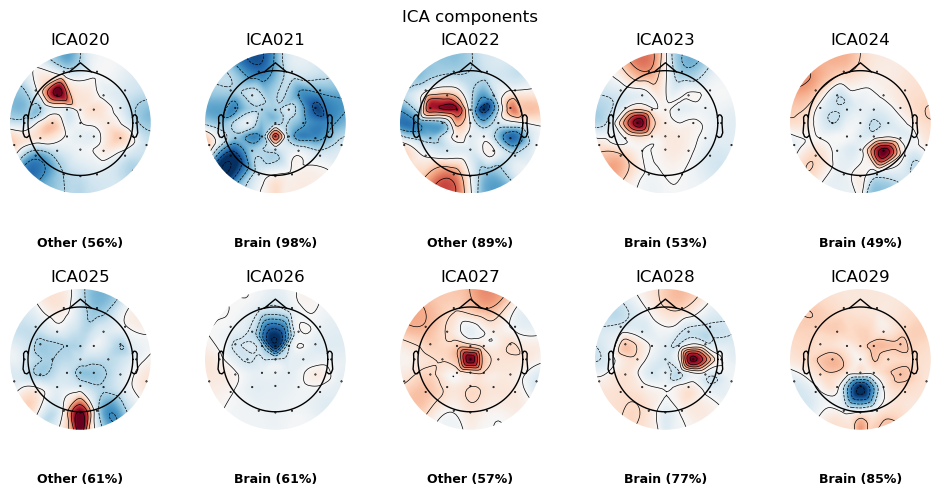

In [171]:
ic_labels = get_iclabel(trials_mne, ica, method='iclabel')

print(ic_labels['labels'])
print(ic_labels['y_pred_proba'])
print("numbe of labels:", len(ic_labels['labels']))

iclabel_visualize(ica, ic_labels, trials_mne)

>NOTE: 
- subj 35 has high heartbeat component. consider to remove (show up as regular troughs on the eeg graph?).
- the authors only removed eye component, whenever the probability is greater than that of brain.

In [172]:
eeg_band_notch = iccomponent_removal(eeg_band_notch, ica, ic_labels, criteria=0.5)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components


# Interpolation

> NOTE:
- maybe stick to the locs of site 2 for better accuracy (not necessery to align with site 1) 
- also maybe no need to remove extra channels as well

In [173]:
eeg_band_notch = interpolation(eeg_band_notch)

No bad channels marked for interpolation


# Compare EEG before and after preprocessing

In [174]:
raw.plot()

qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass


Using pyopengl with version 3.1.10


<mne_qt_browser._pg_figure.MNEQtBrowser(0x428bb9700) at 0x43e879300>

In [175]:
eeg_band_notch.plot()

qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass


Using pyopengl with version 3.1.10


<mne_qt_browser._pg_figure.MNEQtBrowser(0x106f0f2c0) at 0x449cef400>

# Misc

## Remove extra channels from site 2

In [176]:
# # for participants of site 2, need to remove ['O1','O2','CPz'] channels to make sure it has same num of channels as site 1
# channels_to_remove = ['O1','O2','CPz']
# eeg_band_notch.drop_channels(channels_to_remove, on_missing='ignore')

# # left 29 channels which is different from what they have stated in make_erp (they set 30 channels)

## Remove the first few trials from each task

>NOTE:
- author: remove the first 10. do we stick to it?

In [177]:
eeg_final = exclude_early_trials(eeg_band_notch, num_to_exclude=10)

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1': [10002], 'S 11_S 21': [10009, 10016], 'S 31': [10023]}
[10002, 10009, 10016, 10023]
{'S 1': 144, 'S 11_S 21': 144, 'S 31': 144}
Excluded 146 events (first 10 trials of each block).


>NOTE: 
- in theory, 3 tasks x 10 trials x 6 events = 180 events to be exlude
- but there might be some invalid response or to fast/slow reponses that do not have response/feedback

# Epoching & find leftover artifacts

In [178]:
epochs_all = epoching(CONDITIONS_DICT, eeg_final, max=150e-6, min=0.1e-6, tmin=-0.2, tmax=0.6, baseline=(-0.2, 0))

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
Not setting metadata
397 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 397 events and 201 original time points ...
0 b

**Round 1**: if met the channel dropping criteria: mark as bad channel. \
**Round 2**: drop the bad epochs directly

In [179]:
find_bad_channels(epochs_all, reject_criteria=0.20)

--- Channel Rejection Summary ---
Fp1: 0/397 drops (0.0%)
F3: 0/397 drops (0.0%)
F7: 0/397 drops (0.0%)
FC5: 0/397 drops (0.0%)
FC1: 0/397 drops (0.0%)
FCz: 0/397 drops (0.0%)
C3: 0/397 drops (0.0%)
T7: 0/397 drops (0.0%)
TP9: 0/397 drops (0.0%)
CP5: 0/397 drops (0.0%)
CP1: 0/397 drops (0.0%)
Pz: 0/397 drops (0.0%)
P3: 0/397 drops (0.0%)
P7: 0/397 drops (0.0%)
O1: 0/397 drops (0.0%)
Oz: 0/397 drops (0.0%)
O2: 0/397 drops (0.0%)
P4: 0/397 drops (0.0%)
P8: 0/397 drops (0.0%)
TP10: 0/397 drops (0.0%)
CP6: 0/397 drops (0.0%)
CP2: 0/397 drops (0.0%)
CPz: 0/397 drops (0.0%)
Cz: 0/397 drops (0.0%)
C4: 0/397 drops (0.0%)
T8: 0/397 drops (0.0%)
FC6: 0/397 drops (0.0%)
FC2: 0/397 drops (0.0%)
F4: 0/397 drops (0.0%)
F8: 0/397 drops (0.0%)
Fp2: 0/397 drops (0.0%)
---------------------------------
Channels exceeding 20% threshold: []


# Make ERP

use trimmed mean
compare with the original method?

In [180]:
all_evokeds = get_evoked(CONDITIONS_DICT, epochs_all, proportiontocut=0.05)

In [181]:
# using mean amplitude to measure erp amplitude
def calculate_mean_amplitude(evoked, channel_name, tmin, tmax):
    """Calculates the mean amplitude for a channel within a time window."""
    
    # Select the specific channel
    data = evoked.get_data(picks=channel_name)[0] 
    
    # Get the time indices corresponding to the window (tmin, tmax)
    i_start, i_end = evoked.time_as_index([tmin, tmax])
    
    # calculate the mean across time (axis 1)
    mean_val = np.mean(data[i_start:i_end + 1])
    
    return mean_val * 1e6 # Convert Volts to microvolts (µV)

# using peak-to-peak
def calculate_peak_to_peak(evoked, channel_name, tmin, tmax):
    """
    Calculates peak-to-peak within a single time window.
    Finds the minimum (negative peak) and maximum (positive peak) in the same window.
    """
    data = evoked.get_data(picks=channel_name)[0]
    times = evoked.times
    
    # Single search window for both peaks
    i_start, i_end = evoked.time_as_index([tmin, tmax])
    
    # Find minimum (most negative) and maximum (most positive) in this window
    n_idx = i_start + np.argmin(data[i_start:i_end + 1])
    p_idx = i_start + np.argmax(data[i_start:i_end + 1])
    
    n_amplitude = data[n_idx]
    p_amplitude = data[p_idx]
    n_time = times[n_idx]
    p_time = times[p_idx]
    
    # Peak-to-peak difference
    peak_to_peak = (p_amplitude - n_amplitude) * 1e6
    
    return peak_to_peak, n_time * 1000, p_time* 1000, n_amplitude, p_amplitude

- what conditions is this comparing?

In [182]:
win = [k for k in CONDITIONS_DICT.keys() if 'Win' in k]
loss = [k for k in CONDITIONS_DICT.keys() if 'Loss' in k]
valid_win_names = [name for name in win if name in all_evokeds]
valid_loss_names = [name for name in loss if name in all_evokeds]


# calculate average amplitude for win and lose cases
win_evokeds_list = [all_evokeds[name] for name in valid_win_names]
loss_evokeds_list = [all_evokeds[name] for name in valid_loss_names]

erp_grand_win = mne.combine_evoked(win_evokeds_list, weights='equal')
erp_grand_loss = mne.combine_evoked(loss_evokeds_list, weights='equal')
rewp_diff = mne.combine_evoked([erp_grand_win, erp_grand_loss], weights=[1, -1])

# Parameters
channel = 'FCz'
mean_window = [0.240, 0.340] # as set by authors

# Metrics
rewp_mean_amplitude = calculate_mean_amplitude(rewp_diff, channel, *mean_window)
p2p_amp, n_time, p_time, n_val, p_val = calculate_peak_to_peak(rewp_diff, channel, *mean_window)


print(f"RewP Mean Amplitude: {rewp_mean_amplitude:.2f} µV")
print(f"RewP Peak-to-Peak: {p2p_amp:.2f} µV")


RewP Mean Amplitude: 1.36 µV
RewP Peak-to-Peak: 1.64 µV


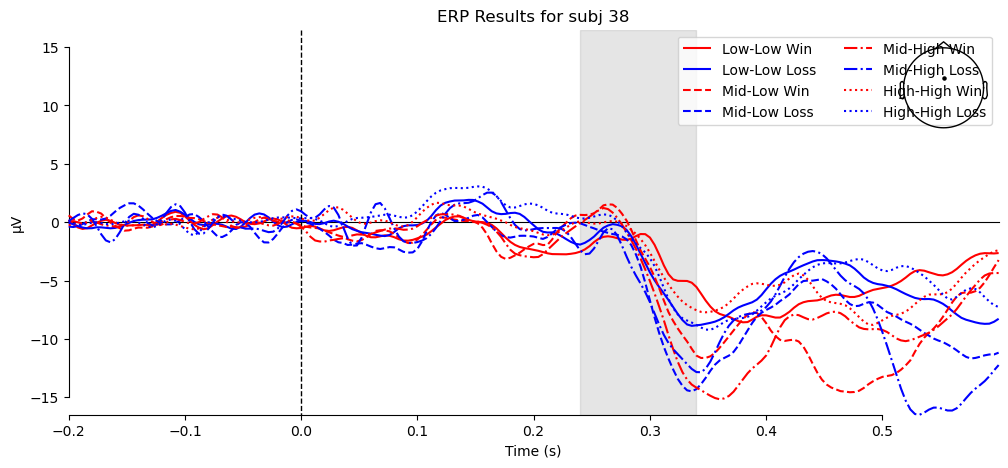

In [183]:
# Define styles for the plot
colors = {
    'Low-Low Win': 'red', 'Low-Low Loss': 'blue',
    'Mid-Low Win': 'red', 'Mid-Low Loss': 'blue',
    'Mid-High Win': 'red', 'Mid-High Loss': 'blue',
    'High-High Win': 'red', 'High-High Loss': 'blue'
}
linestyles = {
    'Low-Low Win': '-', 'Low-Low Loss': '-',
    'Mid-Low Win': '--', 'Mid-Low Loss': '--',
    'Mid-High Win': '-.', 'Mid-High Loss': '-.',
    'High-High Win': ':', 'High-High Loss': ':'
}
plot_erp(all_evokeds, channel, mean_window, colors=colors, linestyles=linestyles, title=f"ERP Results for subj {subject_id}")

In [184]:
print(all_evokeds.keys())

dict_keys(['Low-Low Win', 'Low-Low Loss', 'Mid-Low Win', 'Mid-Low Loss', 'Mid-High Win', 'Mid-High Loss', 'High-High Win', 'High-High Loss'])


Calculated difference for: Low-Low
Calculated difference for: Mid-Low
Calculated difference for: Mid-High
Calculated difference for: High-High


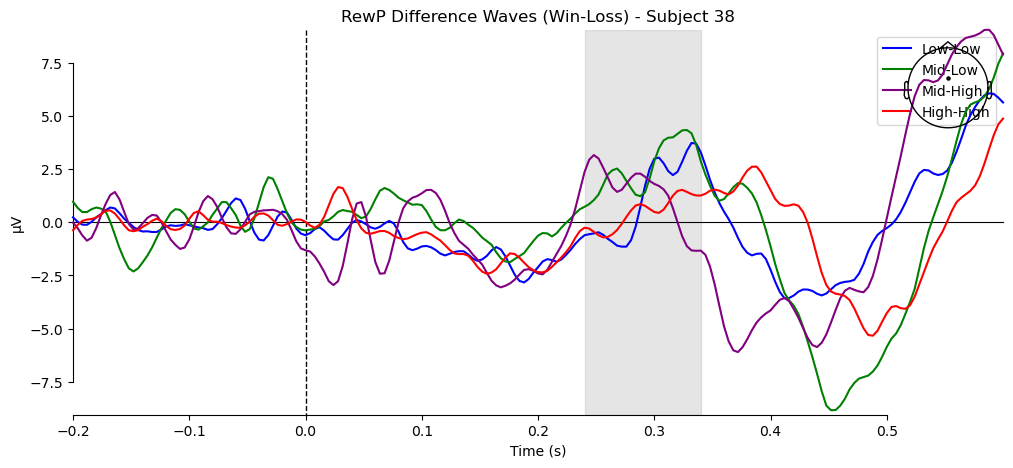

In [185]:
diff_evokeds = {}

cases = [
    ('Low-Low', 'Low-Low Win', 'Low-Low Loss'),
    ('Mid-Low', 'Mid-Low Win', 'Mid-Low Loss'),
    ('Mid-High', 'Mid-High Win', 'Mid-High Loss'),
    ('High-High', 'High-High Win', 'High-High Loss')
]

for case_name, win_cond, loss_cond in cases:
    if win_cond in all_evokeds and loss_cond in all_evokeds:
        # Calculate Difference: Win - Loss
        diff = mne.combine_evoked(
            [all_evokeds[win_cond], all_evokeds[loss_cond]],
            weights=[1, -1]
        )
        diff.comment = case_name # Set name for plotting
        diff_evokeds[case_name] = diff
        print(f"Calculated difference for: {case_name}")
    else:
        print(f"Warning: Missing conditions for {case_name}. Cannot calculate difference.")

colors_diff = {
    'Low-Low': 'blue',  
    'Mid-Low': 'green',   
    'Mid-High': 'purple',  
    'High-High': 'red'  
}

plot_erp(diff_evokeds, channel, mean_window, colors=colors_diff, title=f"RewP Difference Waves (Win-Loss) - Subject {subject_id}")

